3 [опция]. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np


In [40]:
data, target, coef = datasets.make_regression(n_samples=2000, n_features = 1, n_informative = 1, 
                                                 n_targets = 1, noise = 20, coef = True, random_state = 3)

In [41]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(data, 
                                                                                     target, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

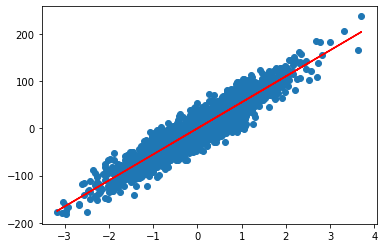

In [42]:
plt.scatter(data,target)
plt.plot(data,coef*data,color = 'red')
plt.show()

In [43]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [8]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = labels.mean()
            

In [9]:
# Расчет критерия Джини

def critery(labels):
        
    return labels.var()

In [13]:
# Расчет качества
def quality(left_labels, right_labels, current_critery):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_critery - p * critery(left_labels) - (1 - p) * critery(right_labels)

In [14]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [15]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_critery = critery(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_critery)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [16]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):
    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [17]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [18]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [20]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    

In [28]:
# Коэф детерминации
def R2(y_pred,y):
    return 1- ((y_pred - y)**2).sum()/((y-y.mean())**2).sum()

In [22]:
# подсчитаем максимальную глубину дерева
def depth_tree(node,n=1):

    # Если лист, то выводим глубину долиста
    if isinstance(node, Leaf):   
        return n
    
    # Рекурсионный вызов функции на положительном поддереве
    l = depth_tree(node.true_branch, n=n+1)

    # Рекурсионный вызов функции на положительном поддереве
    m =  depth_tree(node.false_branch, n=n+1)
    return l,m

In [44]:
my_tree = build_tree(train_data, train_labels)

In [45]:
depth_tree(my_tree)

((((5, (6, 6)),
   (((7, (8, 8)),
     ((((((((((16,
               (((19, 19),
                 ((20, 20),
                  (((22, 22),
                    (((((26, (27, (28, (29, 29)))),
                        ((((29, (30, 30)),
                           ((30, ((32, 32), (32, (33, (34, (35, 35)))))),
                            ((((33, (34, (35, 35))),
                               ((34,
                                 (35,
                                  ((37, (38, (39, (40, 40)))),
                                   ((38, (39, 39)),
                                    ((((41, 41),
                                       (41,
                                        (((44, 44),
                                          (44, (45, (46, (47, 47))))),
                                         ((44, 44),
                                          (44,
                                           ((46, 46),
                                            ((47, (48, (49, 49))),
              

In [46]:
# Изучим качество  ответов для обучающей и тестовой выборки по дереву без ограничения
train_answers = predict(train_data, my_tree)
answers = predict(test_data, my_tree)
train_accuracy = tr_nolimit_dgini =R2(train_answers,train_labels)
test_accuracy = test_nolimit_dgini=R2(answers,test_labels)
print (f'Дерево без ограничений : Качество на обучаеющей выборке {train_accuracy}, качество на тесовой выборке {test_accuracy}')

Дерево без ограничений : Качество на обучаеющей выборке 0.9002147784705588, качество на тесовой выборке 0.8704181155818612


In [51]:
# Создадим функцию с лимитом дерева
def build_tree_limit(data, labels,limit):
    limit-=1
    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0 or limit == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree_limit(true_data, true_labels,limit)
    false_branch = build_tree_limit(false_data, false_labels,limit)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [63]:
for i in range(5,71,5):
    my_tree_limit = build_tree_limit(train_data, train_labels,i)
    train_answers = predict(train_data, my_tree_limit)
    answers = predict(test_data, my_tree_limit)
    train_accuracy = tr_limit_dgini=R2(train_answers,train_labels )
    test_accuracy = test_limit_dgini =R2(answers,test_labels )
    print (f'Дерево c ограниченим на {i} . Качество на обучаеющей выборке {train_accuracy}, качество на тесовой выборке {test_accuracy}')


Дерево c ограниченим на 5 . Качество на обучаеющей выборке 0.3133292663137208, качество на тесовой выборке 0.2312140503942861
Дерево c ограниченим на 10 . Качество на обучаеющей выборке 0.49339277727986897, качество на тесовой выборке 0.431506729985644
Дерево c ограниченим на 15 . Качество на обучаеющей выборке 0.5999605671778336, качество на тесовой выборке 0.5429524545476568
Дерево c ограниченим на 20 . Качество на обучаеющей выборке 0.6746549141775617, качество на тесовой выборке 0.628938453490427
Дерево c ограниченим на 25 . Качество на обучаеющей выборке 0.7654392779210744, качество на тесовой выборке 0.7274723336975965
Дерево c ограниченим на 30 . Качество на обучаеющей выборке 0.8283521935275505, качество на тесовой выборке 0.7997016929620777
Дерево c ограниченим на 35 . Качество на обучаеющей выборке 0.8507501481887092, качество на тесовой выборке 0.8208756281814524
Дерево c ограниченим на 40 . Качество на обучаеющей выборке 0.8730862443164298, качество на тесовой выборке 0.847